# Package imports and config

In [2]:
# Data handling
import collections
import sqlite3
import pandas as pd
import json

# NLP tools
import re
import nltk
import gensim, logging
from gensim.models import Word2Vec

# Visualization
from IPython.display import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud
%matplotlib inline

import time
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', )

# Import the data

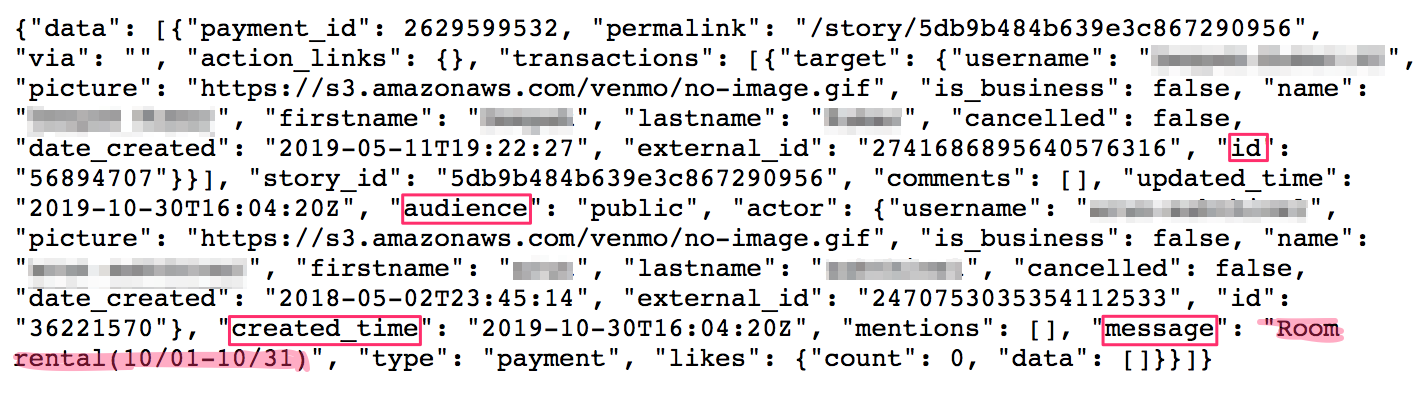

In [16]:
Image(filename='/home/jovyan/work/data/sample.png')

In [2]:
def sqlite_to_pandas(db_path, query):
    """ Read sqlite transactions and store in pandas dataframe
    
    Use sqlite3 to connect and query sql database and store result in pandas.
    
    Parameters:
    -----------
    db_path: (str) file path to database
    query: (str) SQL query
    
    Returns:
    -------
        Pandas DataFrame w/ result from SQL query.
    
    """
    try:
        conn = sqlite3.connect(db_path) # connect to SQLite database
        return pd.read_sql_query(sql=query, con=conn)
    except Exception as e:
        raise e

def sqlite_to_docs(db_path, query):
    """
    Read sqlite transactions and return iterator
    
    Parameters:
    ----------
    db_path: (string) file path to database
    query: (str) SQL query
        
    Returns:
    --------
    transaction iterator
    
    """
    try:
        conn = sqlite3.connect(db_path) # connect to SQLite database
        cursor = conn.cursor()
        return cursor.execute(query)
    except Exception as e:
        raise e

In [17]:
# Connect to SQLite database, query table and preview in dataframe
db_path = '/home/jovyan/work/data/venmo.sqlite'
query = "SELECT * FROM pmt_2017 LIMIT 10;"
pmt_df = sqlite_to_pandas(db_path, query)
pmt_df.head()

,created_date,created_time,message
0,2017-01-01,23:59:59,for Netflix bills
1,2017-01-01,23:59:59,🇦🇷🎉🍻
2,2017-01-01,23:59:59,Internet
3,2017-01-01,23:59:59,🍾🎄🍕🍷🍻🍳
4,2017-01-01,23:59:59,#whoatethepork2016


# Explore data

In [18]:
#1. What are people paying for? Get most frequent terms (words/emojis)


## Tokenize transactions
def word_tokens(docs):
    """
    regex word tokenizer
    """
    pattern = r'[a-zA-Z0-9\'():_#$\/\-\U00010000-\U0010ffff]+'
    regex = re.compile(pattern, flags=re.UNICODE) 
    for doc in docs:
        yield regex.findall(doc[0].lower())



## Compute word frequency
def term_freq(docs):
    """calculate term frequency from tokenized documents."""
    frequency = collections.Counter()
    for doc in docs:
        for word in doc:
            frequency[word] += 1
    return frequency

In [6]:
# Connect to SQLite database, query table and return documents iterator
# db_path = '/home/jovyan/work/data/venmo.sqlite'
query = "SELECT message FROM pmt_2017 LIMIT 10;"
docs = sqlite_to_docs(db_path, query)

# Word frequency for entire dataset
start = time.time()
tokens = word_tokens(docs)
word_freq = term_freq(tokens)
elapsed = time.time() - start
print(elapsed)

In [10]:
# Persist term frequency dict to disk

# with open('/home/jovyan/data/sample.json', 'w') as f:
#     json.dump(word_freq, f)

# Reload from disk
with open('/home/jovyan/work/data/digital_pmt_2017_word_cnt.json', 'r') as f:
    word_freq = collections.Counter(json.load(f))
    
print(word_freq.most_common(10))

[('for', 8758881), ('the', 6312645), ('and', 5829246), ('you', 4814436), ('food', 3654702), ('i', 3645415), ('s', 3594227), ('a', 3472829), ('to', 2697389), ('uber', 2517701)]


In [11]:
# Make stopword list
stop_words = nltk.corpus.stopwords.words('english')

ext_stop_words = [
    'new', 'thank', 'thanks', 'thx', 'happy', 'good', 'great', 'best', 'that', 'night', 
    'day', 'week', 'just', 'back', 'love', 'com', 'time', 'times', 'fun', 'know', 'life', 
    'thing', 'things', 'bill', 'best', 'sorry', 'love', 'https', 'like', 'let', 'because', 
    'hot', 'favorite', 'bad', 'dat', 'forgot', 'hey', 'last', 'ur', 'lol', 'buy', 'nice', 'rest', 
    'getting', 'cause', 'plus', 'need', 'b', 'u', 'get', 'go', 'n', 'hi', 'ya', 'da', 'much',
    '1', 'one', '2', 'two'
]

for word in ext_stop_words: 
    stop_words.append(word)

# Remove stop words
for stop_word in stop_words:
    word_freq.pop(stop_word, None)

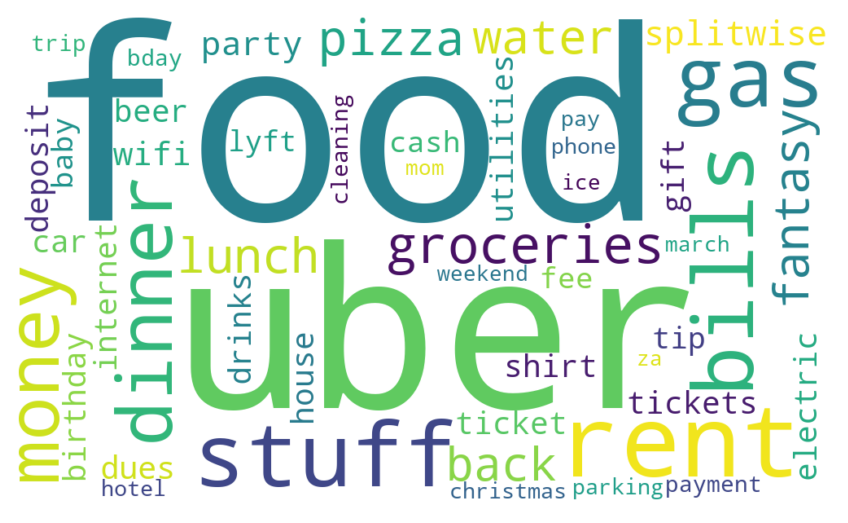

In [19]:
# Make wordcloud
top_ = word_freq.most_common(50)
word_cloud = WordCloud(width=1000, height=600, background_color='white', min_font_size=16)
plt.figure(dpi=175)
plt.imshow(word_cloud.generate_from_frequencies(dict(top_)), interpolation='bilinear')
plt.axis('off')
plt.show()

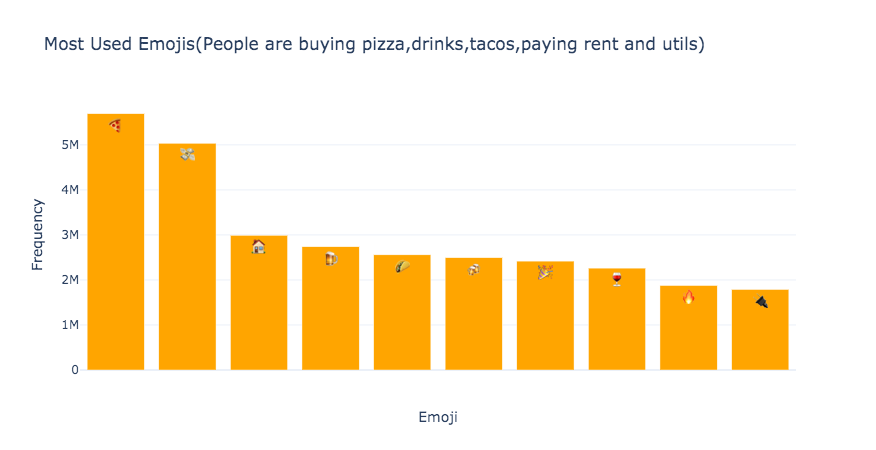

In [17]:
#2. Load emoji frequency dict
with open('/home/jovyan/work/data/digital_pmt_2017_lone_emoji_cnt.json', 'r') as f:
    emoji_freq = collections.Counter(json.load(f))

# Make emoji plot
top_emoji = emoji_freq.most_common(10)
emoji_freq_df = pd.DataFrame(top_emoji, columns=['Emoji', 'Frequency'])
# fig = px.bar(data_frame=emoji_freq_df, x='Emoji', y='Frequency', text='Emoji', opacity=0.9, 
#              title='Most Used Emojis (People are buying pizza, drinks and paying rent and utils)', 
#              height=450, width=700)
# fig.show()


fig = go.Figure(data=[go.Bar(x=emoji_freq_df['Emoji'], 
                             y=emoji_freq_df['Frequency'], 
                             marker_color='orange', 
                             text=emoji_freq_df['Emoji'],
                             textposition='auto'
                            )
                     ]
               )

fig.update_layout(
    height=450,
    width=700,
    template='plotly_white',
    xaxis_tickangle=-45,
    title_text='Most Used Emojis(People are buying pizza,drinks,tacos,paying rent and utils)',
    yaxis_title='Frequency',
    xaxis_title='Emoji'
    
)
fig.show()

In [12]:
#3. When do people use venmo?

query = "SELECT created_date AS Date, COUNT(message) AS Transactions FROM pmt_2017 GROUP BY created_date;"
# active_df = sqlite_to_pandas(db_path, query)

# Save
# active_df.to_csv('/home/jovyan/data/total_transactions_day.csv')
# print('Total transactions: %i' % active_df.Transactions.sum())

# Load
active_df = pd.read_csv('/home/jovyan/work/data/total_transactions_day.csv', 
                        usecols=['Date', 'Transactions'])

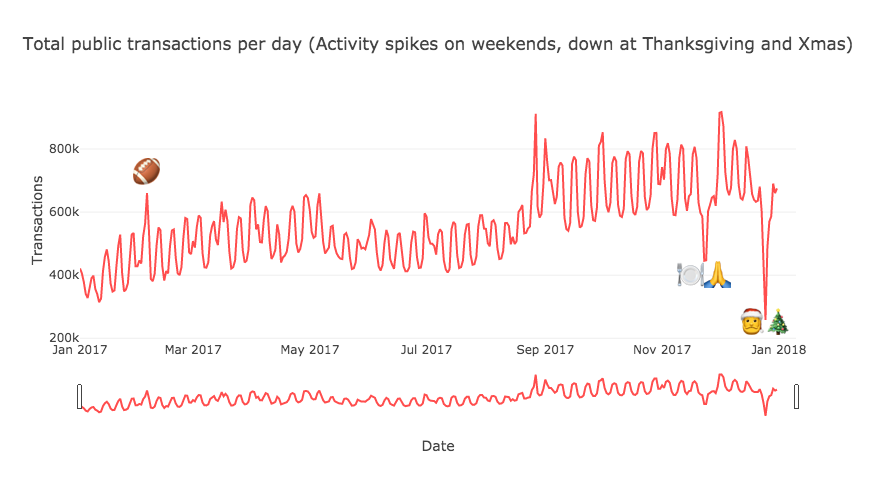

In [13]:
# Plot user activity
fig = go.Figure()
fig.add_trace(go.Scatter(x=active_df['Date'], y=active_df['Transactions'], line_color='red', opacity=0.7))
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Transactions')
fig.update_layout(
    height=500,
    width=900,
    title_text='Total public transactions per day (Activity spikes on weekends, down at Thanksgiving and Xmas)',
    xaxis_rangeslider_visible=True, template='xgridoff', annotations=[
        go.layout.Annotation(
        x='2017-12-25',
        y=250000,
        text='🎅🎄',
        showarrow=False,
        font=dict(size=27)
        ),
        go.layout.Annotation(
        x='2017-11-23',
        y=400000,
        text='🍽🙏',
        showarrow=False,
        font=dict(size=27)
        ),
        go.layout.Annotation(
        x='2017-02-05',
        y=725000,
        text='🏈',
        showarrow=False,
        font=dict(size=27)
        )
    ])
fig.show()

In [522]:
#4. What were people up to for superbowl Sunday (Feb 5th)?
query = "SELECT message FROM pmt_2017 WHERE created_date BETWEEN '2017-02-05' AND '2017-02-05';"
superbowl_wknd_docs = sqlite_to_docs(db_path, query)
tokens = word_tokens(superbowl_wknd_docs)
superbowl_wknd_word_freq = term_freq(tokens)
elapsed = time.time() - start

# Remove stopwords
for stop_word in stop_words:
    superbowl_wknd_word_freq.pop(stop_word, None)

# Most frequent terms
print(superbowl_wknd_word_freq.most_common(10))

#---
# Playing superbowl squares, watching the superbowl, eating pizza and drinking 
#---

[('squares', 14702), ('food', 14203), ('super', 14012), ('bowl', 13474), ('🍕', 13099), ('🏈', 12473), ('uber', 10990), ('🍻', 5884), ('🍺', 5663), ('stuff', 3754)]


# Build Word2Vec model

In [23]:
# Generate tokenized document iterator
class Transactions(object):
    def __init__(self, db_path, query):
        self.db_path = db_path
        self.query = query
    
    def __iter__(self):
        try:
            conn = sqlite3.connect(db_path) # connect to SQLite database
            cursor = conn.cursor()
            docs = cursor.execute(query)
            pattern = r'[a-zA-Z0-9\'():_#$\/\-\U00010000-\U0010ffff]+'
            # converts expression to a RegexObject for efficiency
            regex = re.compile(pattern, flags=re.UNICODE) 
            for doc in docs:
                # yield doc[0]
                yield regex.findall(doc[0].lower())
        except Exception as e:
            raise e

In [5]:
# Train w2v model on transactions
query = "SELECT message FROM pmt_2017;"
# docs_w2v = Transactions(db_path, query)

# Build word2vec model
# The `min count` param removes low frequency terms
# The `size` param is the size of the word vectors, 10-100s
# The `worker` param allows parallelization on n cores, requires cython to be installed
start = time.time()

w2v_model = gensim.models.Word2Vec(docs_w2v, size=200, window=5, min_count=100, workers=4)
elapsed = time.time() - start
print(elapsed)

25230.681203842163


In [3]:
# Persist trained model
# w2v_model.save('../data/w2v_model_word_emoji_full')

# Reload model
w2v_model = Word2Vec.load('/home/jovyan/work/models/w2v_model_word_emoji_full')

In [4]:
# Finds words/emoji that occur in the same context
similar = w2v_model.wv.most_similar('🍆', topn=1)
print((similar))

[('🍑', 0.777560830116272)]


In [11]:
# Model learns slang for certain transactions 
similar = w2v_model.wv.most_similar(positive=['marijuana'], topn=10)
print(similar)

[('weed', 0.7507795095443726), ('cannabis', 0.7483189105987549), ('methamphetamine', 0.7173596620559692), ('ketamine', 0.691846489906311), ('xanax', 0.6805106401443481), ('mdma', 0.672141432762146), ('methamphetamines', 0.6707491278648376), ('narcotics', 0.6688754558563232), ('heroin', 0.6675798892974854), ('medicinal', 0.6673850417137146)]
